# EDA: K-Nearest Neighbors & Credit Card Fraud

## **1.** About the Dataset
This project uses a credit card fraud dataset [available on Kaggle](https://https://www.kaggle.com/mlg-ulb/creditcardfraud).
<br />
<br />
This notebook uses a scaled subset of the above credit card fraud dataset, detailed in the adjacent notebook, 'clean_creditCardFraud.ipynb'. The subset contains 1-28 'V-n' features plus 'Time' and 'Amount'. There are an equal number of fraud [1] and non-fraud [0] cases.
<br />
<br />
View our initial check and clean of the data in ./clean_CC-fraud.ipynb

## **2.** Imports & Settings

In [ ]:
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

pd.set_option('display.max_rows', 200)

---

## **3.** Load Data
Here we load the data from Google Drive. The data can also be accessed from a relative path for use with Jupyter Notebooks/Lab.


### **3.1.** Load Data w/ Jupyter Notebooks/Lab
```
# Run this code if using Jupyter Notebooks/Lab
df = pd.read_csv('./data/robust_sub.csv')
```

### **3.2.** Access & Load Data w/ Google Drive

In [ ]:
# Run this cell if using Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/KNN_creditCardFraud/data/robust_sub.csv'
df = pd.read_csv(path)

---

## **4.** Exploration & Feature Selection
Our goal is to build an effective K-Nearest Neighbors model from this data to predict a binary classification, fraud or not fraud. Because the dataset is now clean, scaled, without missing values, and balanced between our classifications we can move forward with identifying features that may have a strong correlation to our classifications.

### **4.1.** Detail
First, let's review a few characteristics of our dataset.

In [ ]:
df.head()

Time        V1        V2        V3  ...       V27       V28    Amount  Class
0 -0.313926 -0.659173  0.153106 -0.700699  ...  1.889813  0.440909 -0.704564      1
1  0.029096 -0.702822  0.923673 -0.941998  ...  3.615950 -1.586721  0.627206      1
2 -0.362898 -0.992665  2.068306 -1.226761  ...  2.201711  0.627581  0.405082      1
3 -0.270763 -0.259096 -1.803426 -0.332195  ...  0.493230  1.745807  1.009467      1
4  0.931107 -0.359316  0.475312  0.410818  ... -1.492037 -0.516357  0.206662      0

[5 rows x 31 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    984 non-null    float64
 1   V1      984 non-null    float64
 2   V2      984 non-null    float64
 3   V3      984 non-null    float64
 4   V4      984 non-null    float64
 5   V5      984 non-null    float64
 6   V6      984 non-null    float64
 7   V7      984 non-null    float64
 8   V8      984 non-null    float64
 9   V9      984 non-null    float64
 10  V10     984 non-null    float64
 11  V11     984 non-null    float64
 12  V12     984 non-null    float64
 13  V13     984 non-null    float64
 14  V14     984 non-null    float64
 15  V15     984 non-null    float64
 16  V16     984 non-null    float64
 17  V17     984 non-null    float64
 18  V18     984 non-null    float64
 19  V19     984 non-null    float64
 20  V20     984 non-null    float64
 21  V21     984 non-null    float64
 22  V2

In [ ]:
# Check distrobution
no_fraud_percent = round((df['Class'].value_counts()[0] / len(df)) * 100, 2)
fraud_percent = round((df['Class'].value_counts()[1] / len(df)) * 100, 2)

print(f'No Fraud: {no_fraud_percent} percent of dataset')
print(f'Fraud: {fraud_percent} percent of dataset')

No Fraud: 50.0 percent of dataset
Fraud: 50.0 percent of dataset


### **4.2.** Correlation Matrix

A correlation matrix or heatmap, using Pearson's Correlation Coefficient, is a simple visual representation of the association between two variables. The correlation is measured on a scale of 1 (positive) to -1 (negative) with values at 0 representing no correlation.
<br />
<br />
Pearson's Correlation Coefficient is the covariance of each x and y value (each x and y value minus their respective mean) divided by the product of their standard deviations, in order to scale the value to the -1 to 1 scale mentioned above. It is represented by the following equation:


$$r = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2}\sum{(y_i - \bar{y})^2}}}$$

Where:
>
**r**	=	correlation coefficient<br />
**$x_i$**	=	values of the x-variable in a sample<br />
**$\bar{x}$**	=	mean of the values of the x-variable<br />
**$y_{i}$**	=	values of the y-variable in a sample<br />
$\bar{y}$	=	mean of the values of the y-variable
>

We look at the comparison of each feature to "Class" on the correlation matrix below and notice V4 and V11 show a moderate positive correlation to class. At the other end of the spectrum, V3, V9, V10, V11, V12, V14, V16, and V17 all show a low to moderate inverse correlations to class.
<br />
<br />
We will take note of these correlations for future use in our feature-selected model.

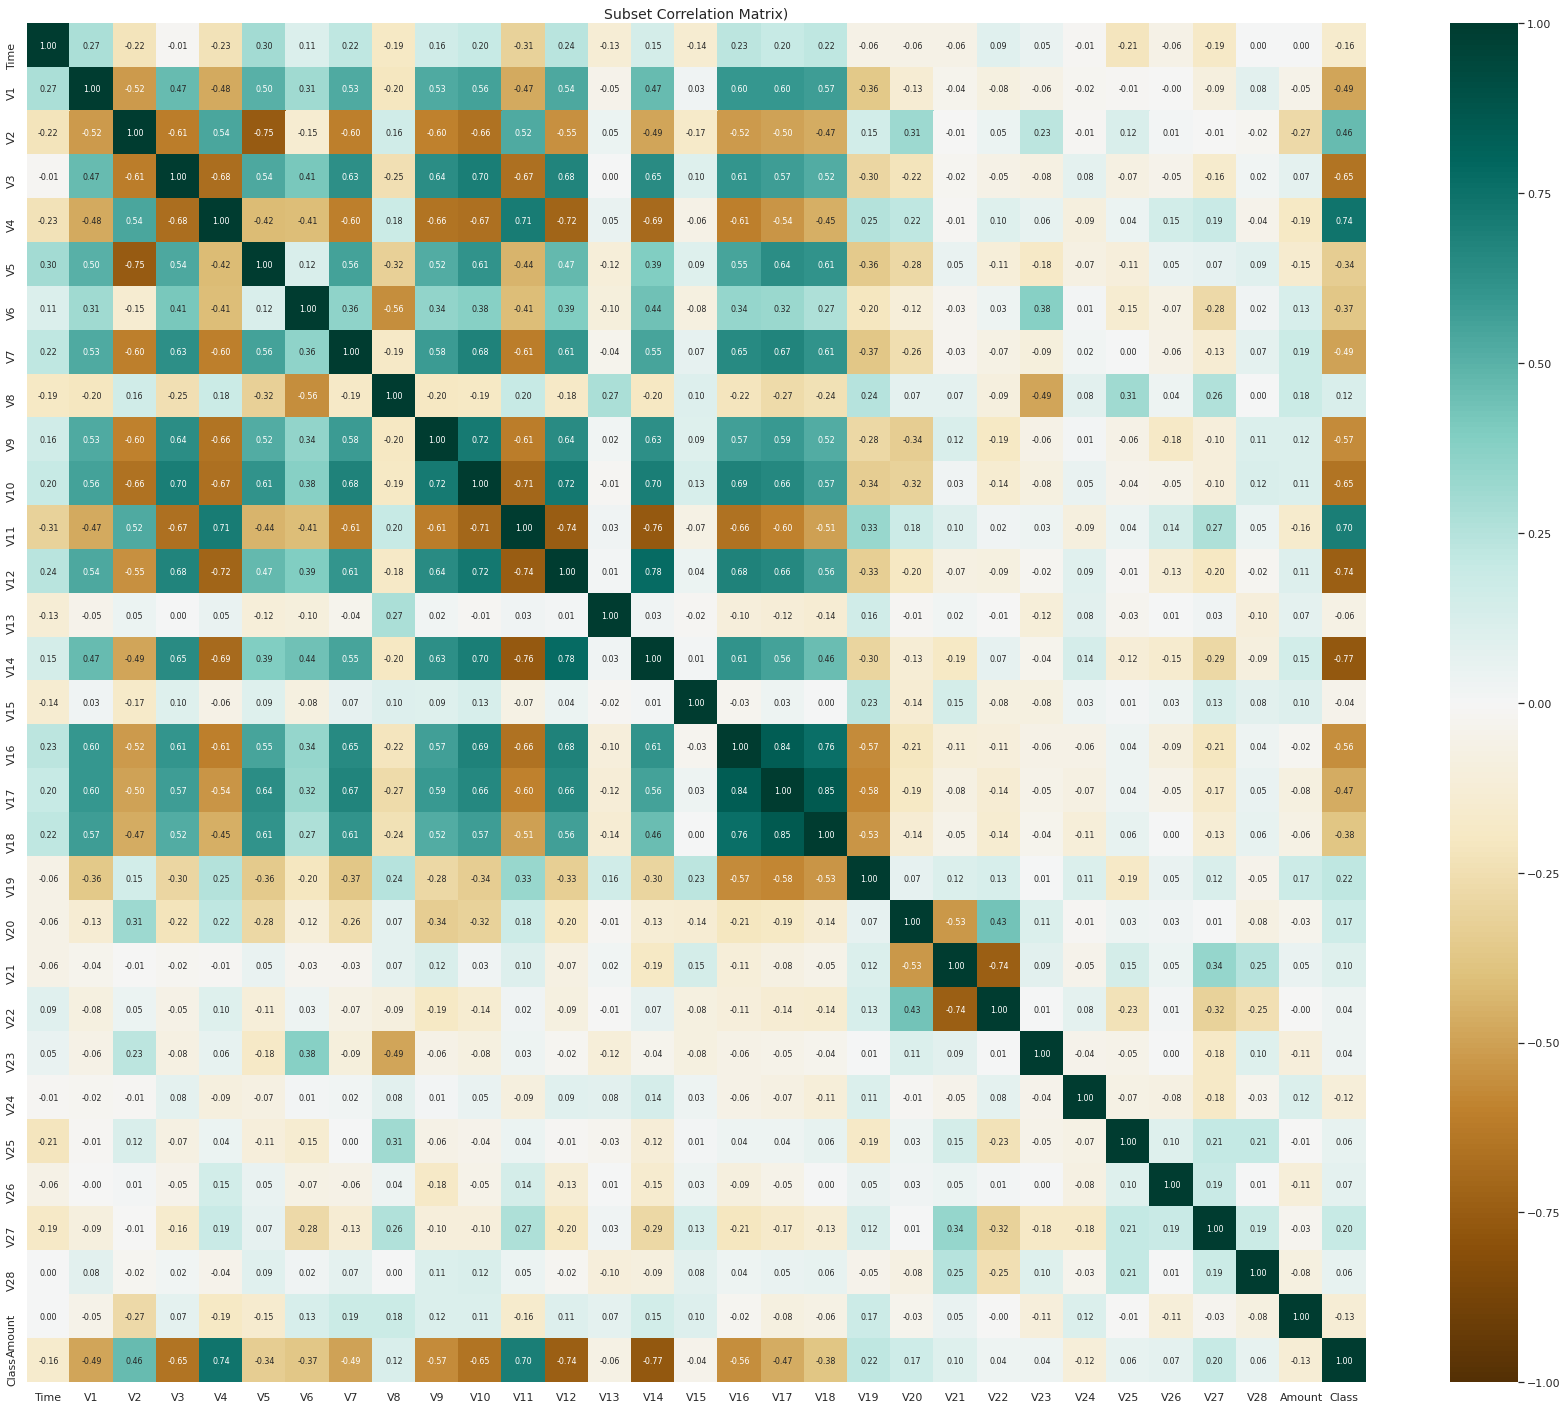

In [ ]:
sns.set()

f, (ax) = plt.subplots(figsize=(30,25))

# Entire DataFrame
subset_corr = df.corr()

sns.heatmap(subset_corr, 
            annot=True, 
            fmt='.2f', 
            cmap='BrBG', 
            annot_kws={'size':8}, 
            vmin=-1, 
            vmax=1)

ax.set_title('Subset Correlation Matrix)', fontsize=14)

plt.show()

### **4.3.** Scatter Pairplot
Let's zoom in on some of the features above that show a moderate correlation to class. We'll also change our perspective. Using scatterplots with a regression line, we can further understand our features' association with our classes.
<br />
<br />
Focusing on the "Class" column below, we see pronounced positive and inverse relationships between our selected features and our classes, which, using KNN, is likely to better inform our model than features that do not display such an apparent correlation. 'V25' is plotted alongside our selected features to illustrate this difference—note the comparatively flat regression line.

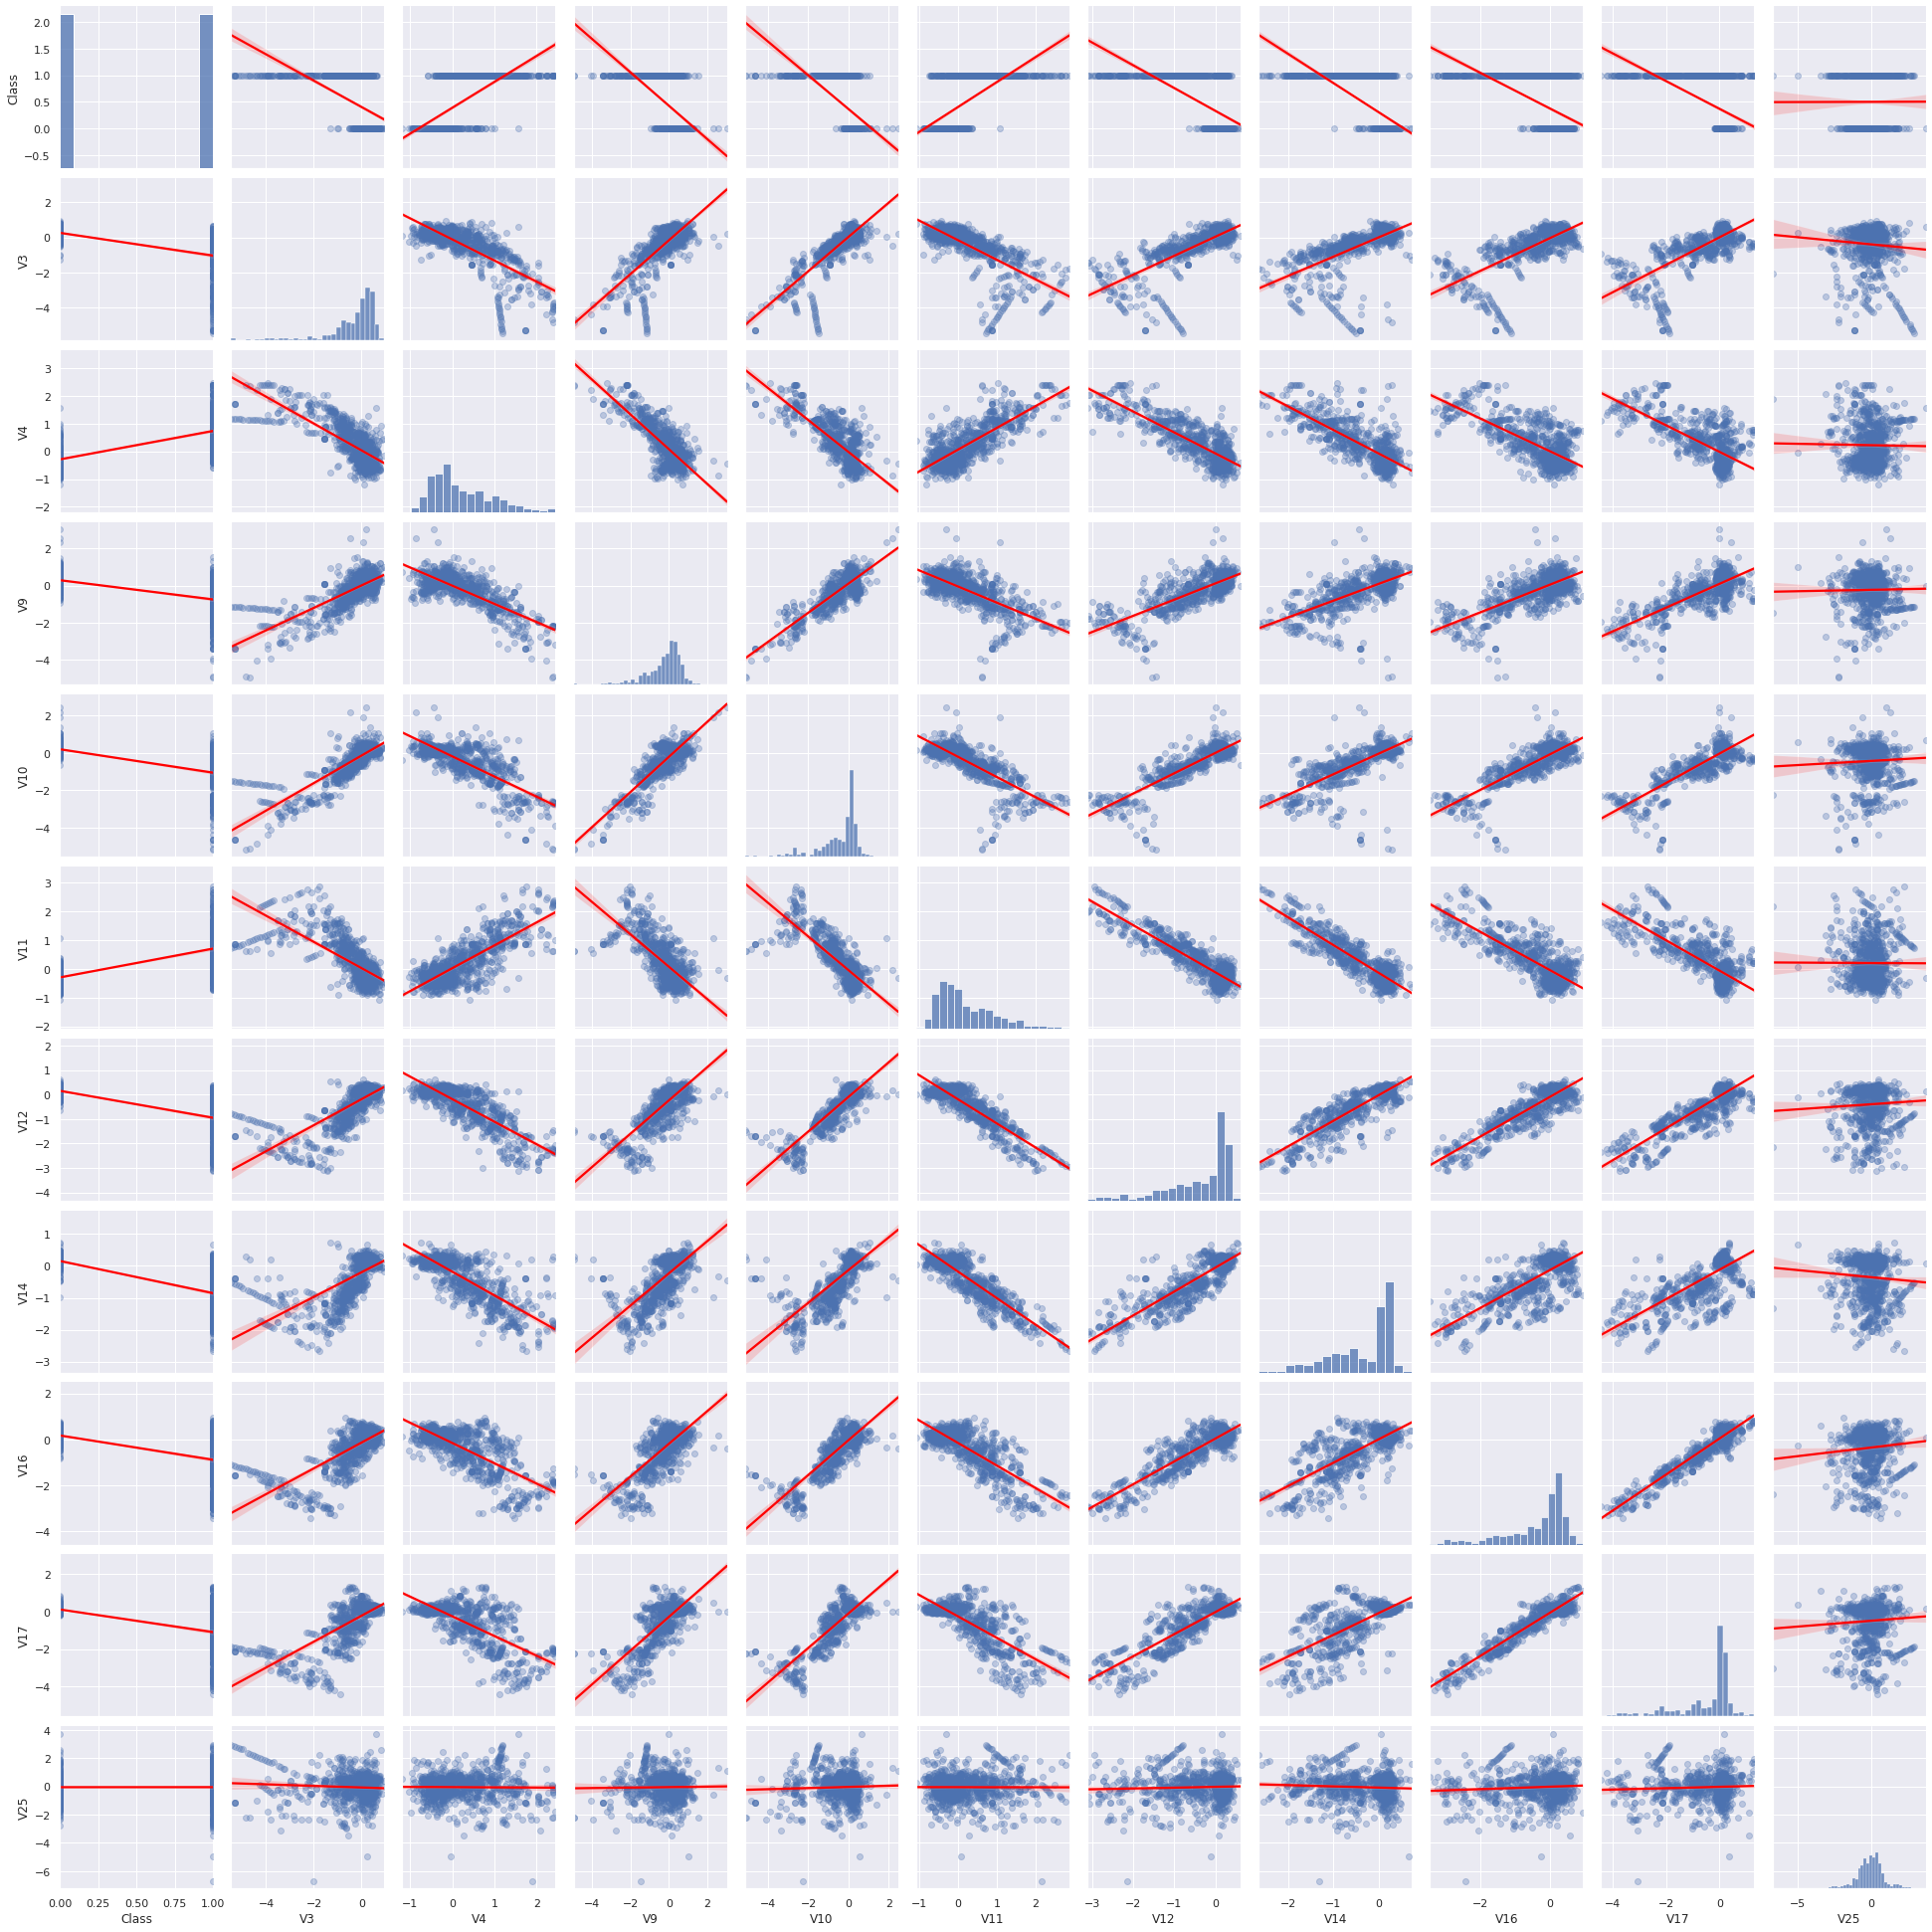

In [ ]:
#scatterplot
sns.set()
cols = ['Class', 'V3', 'V4', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V25']

sns.pairplot(df[cols], 
             height = 2.5, 
             kind='reg', 
             plot_kws={'scatter_kws': {'alpha': 0.3}, 
                       'line_kws':{'color':'red'}})
plt.show()

#### 4.3.1. Scatter Pairplot w/Hue : Significant Correlation
Additionally, we can further visualize how well our classifications are defined in regards to features that are highly-correlated to 'Class' by casting hue='Class' to our pairplot. We notice, in particular, a distinct separation between classifications 0 and 1 not only in the scatter plots but also in the histograms defining the distribution of values for each feature.

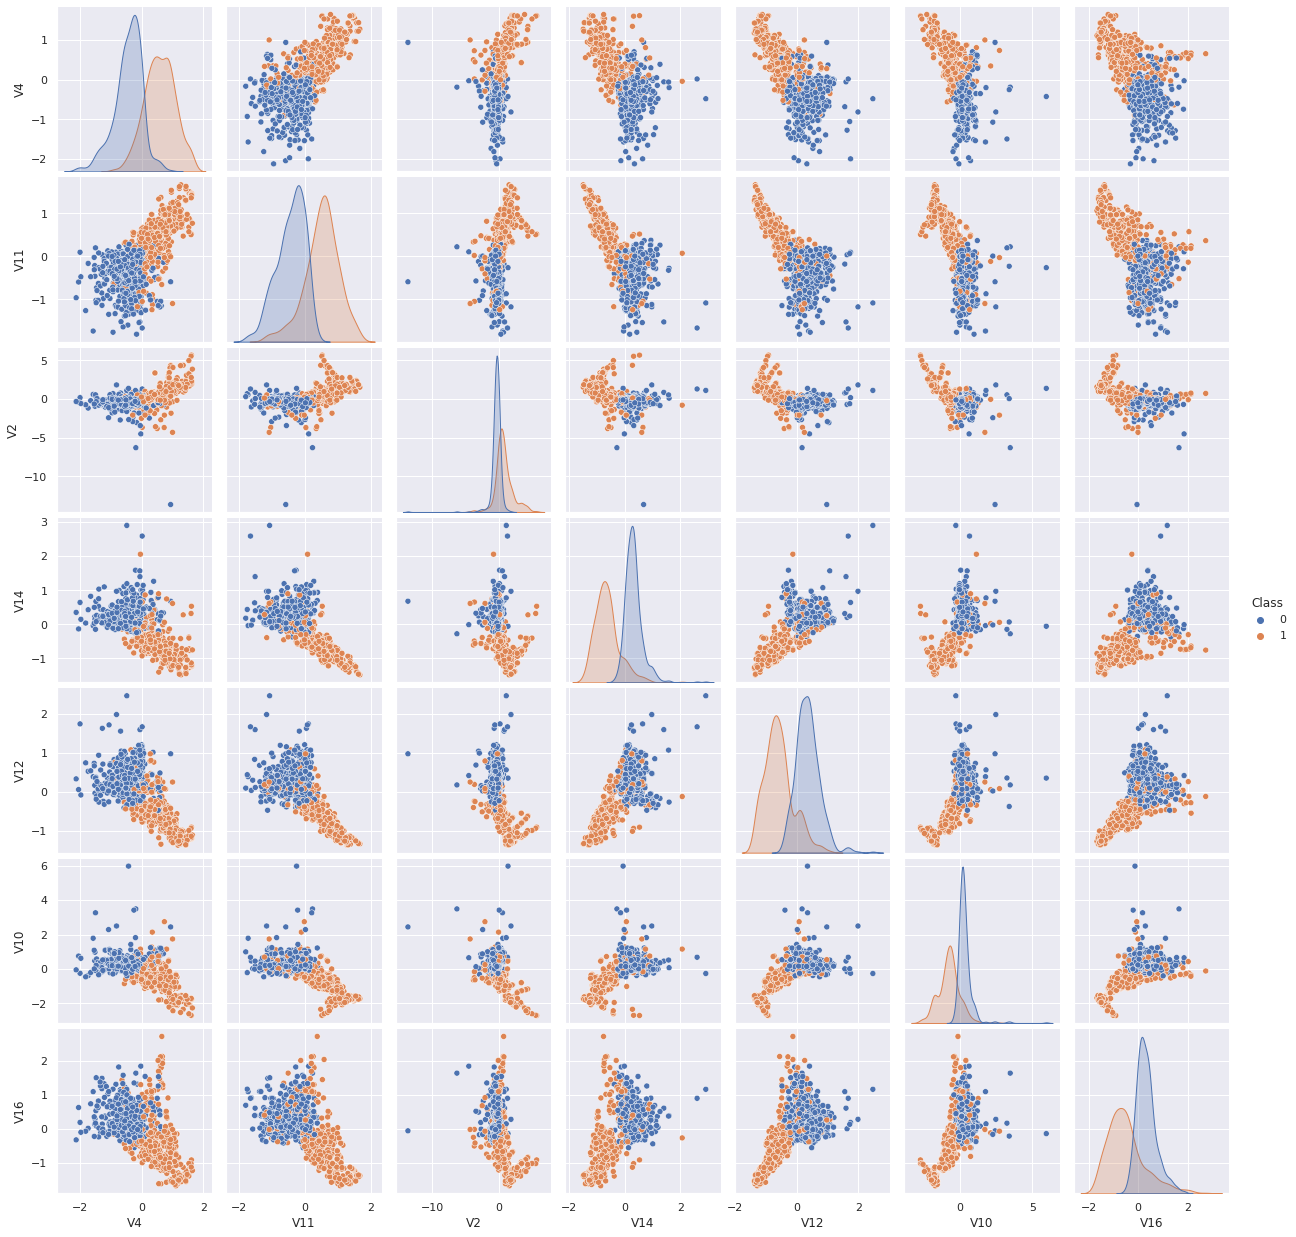

In [ ]:
cols = ['Class', 'V4', 'V11', 'V2', 'V14', 'V12', 'V10', 'V16']

sns.pairplot(df[cols], height = 2.5, hue='Class')

plt.show()

#### **4.3.2.** Scatter Pairplot w/Hue: No Correlation
By contrast, if we visualize features with a low correlation to class in the same way, we find indistinct distributions.

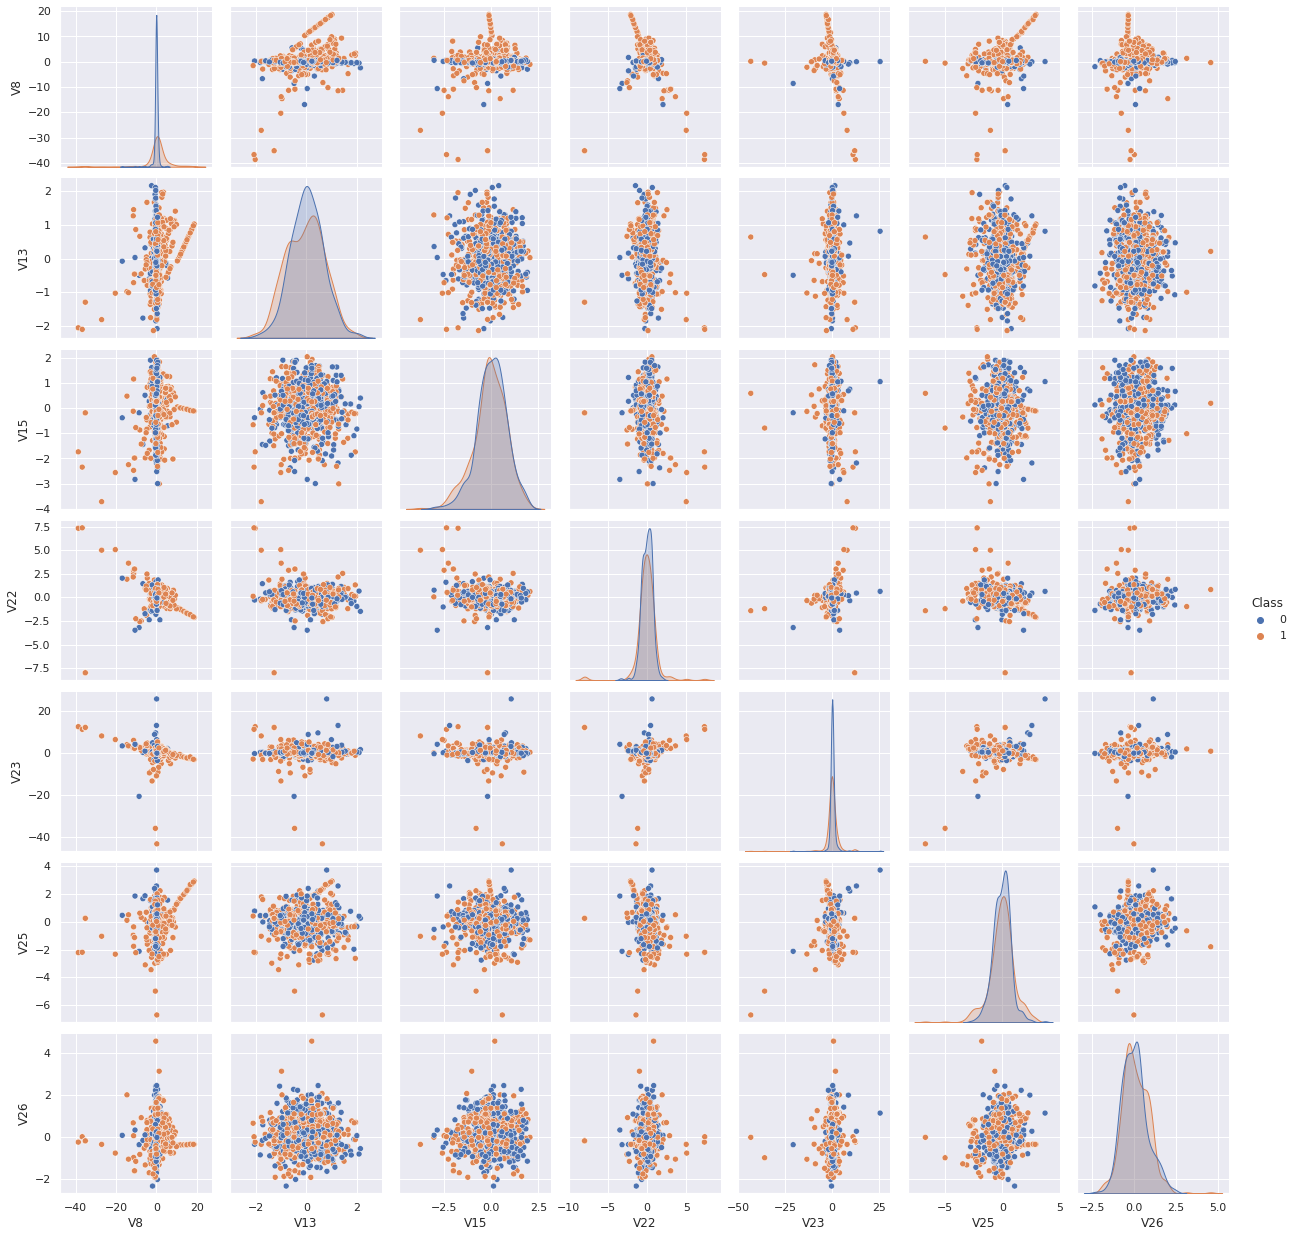

In [ ]:
low_cols = ['Class', 'V8', 'V13', 'V15', 'V22', 'V23', 'V25', 'V26']

sns.pairplot(df[low_cols], height = 2.5, hue='Class')

plt.show()

### **4.4.** 3D Modeling
We can develop a more intuitive understanding of how various feature combinations will plot in n-th dimensional space by adding a dimension to our scatterplots.
<br />
<br />
Below, we can see four different feature combinations and plot them in 3D to observe differences in how our classifications are grouped. We'll take a particular look at:
1. A selection of features with a mix of positive and inverse correlations to class
2. A selection of features that only show a positive correlation to class
3. A selection of features that only show an inverse correlation to class
4. A selection of features that have a low correlation to class

We can rotate the plots to view the groupings.

In [ ]:
# initialize figure with four 3D subplots
fig = make_subplots(
    rows=2, cols=2, subplot_titles=("Pos & Inverse Correlation", "Pos Correlation", 
                                    "Inverse Correlation", "Low Correlation"), 
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
           [{'type': 'surface'}, {'type': 'surface'}]])

# adding surfaces to subplots

# pos & inv correlation
fig.add_trace(
    go.Scatter3d(x=df['V14'], y=df['V12'], z=df['V11'], 
                 ids=['a', 'ew', 'w'], 
                 showlegend=False, 
                 mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=df['Class'], 
        colorscale=["#2b62bb", "#e37030"]
    )),
    row=1, col=1)

# pos correlation only
fig.add_trace(
    go.Scatter3'], y=df['V4'], z=df['V11'], 
                 showlegend=False, 
                 mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=df['Class'], 
        colorscale=["#2b62bb", "#e37030"]
    )),
    row=1, col=2)

# inv correlation only
fig.add_trace(
    go.Scatter3d(x=df['V14'], y=df['V12'], z=df['V10'], 
                 showlegend=False, 
                 mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=df['Class'], 
        colorscale=["#2b62bb", "#e37030"]
    )),
    row=2, col=1)

# low correlation
fig.add_trace(
    go.Scatter3d(x=df['V8'], y=df['V15'], z=df['V24'], 
                 showlegend=False, 
                 mode='markers',
    marker=dict(
        size=5,
        opacity=0.8,
        color=df['Class'], 
        colorscale=["#2b62bb", "#e37030"]
    )),
    row=2, col=2)

fig.update_layout(
    title_text='Plots with Differently Correlated Variables',
    height=1000
)

Below, we offer a larger view for one of the above. Uncomment/Comment blocks below to view different plots.

In [ ]:
# turn classes into an object for nice plotly legend
df['class_obj'] = df['Class'].astype(object)

# low correlation
# fig = px.scatter_3d(df, 
#                     x='V8', y='V15', z='V24', 
#                     color='class_obj', 
#                     size_max=18, 
#                     opacity=0.7, 
#                     height=600, 
#                     range_color=(0,1), 
#                     color_discrete_sequence=["#e37030", "#2b62bb"])

# pos correlation only
fig = px.scatter_3d(df, 
                    x='V2', y='V4', z='V11', 
                    color='class_obj', 
                    size_max=18, 
                    opacity=0.7, 
                    height=600, 
                    range_color=(0,1), 
                    color_discrete_sequence=["#e37030", "#2b62bb"])

# inv correlation only
# fig = px.scatter_3d(df, 
#                     x='V14', y='V12', z='V10', 
#                     color='class_obj', 
#                     size_max=18, 
#                     opacity=0.7, 
#                     height=600, 
#                     range_color=(0,1), 
#                     color_discrete_sequence=["#e37030", "#2b62bb"])


# pos and inv correlation
# fig = px.scatter_3d(df, 
#                     x='V14', y='V12', z='V11', 
#                     color='class_obj', 
#                     size_max=18, 
#                     opacity=0.7, 
#                     height=600, 
#                     range_color=(0,1), 
#                     color_discrete_sequence=["#e37030", "#2b62bb"])


fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), legend=dict(
    yanchor="top",
    y=0.95,
    xanchor="left",
    x=0.05
))


fig.update(layout_coloraxis_showscale=False)

---

## **5.** Conclusion
Observing how well-clustered certain features are in both two and three-dimensional space by comparison to less-highly correlated features, we hope to see a difference between a KNN model that uses Feature Selection and one that does not. Through the feature-selection process, we are reducing noise and, by extension, amplifying the difference between cases of fraud and legitimate transactions.
<br />
<br />
We test these expectations in our modeling notebook, ./model-KNN-subset_CC-fraud.ipynb
